# Введение в регуляризацию для глубоких нейронных сетей



Этот урок познакомит вас с принципами регуляризации, необходимыми для успешного обучения глубоких нейронных сетей. На этом уроке вы будете:

1. Понимать необходимость регуляризации сложных моделей машинного обучения, особенно глубоких сетей.
2. Знать, как применять регуляризацию на основе ограничений, используя методы L1 и L2.
3. Понять и применить концепцию дополнения данных.
4. Знать, как применять регуляризацию отсева.
5. Понять и применить раннюю остановку.
6. Понимать преимущества различных методов регуляризации и знать, когда их применять в комбинации.




## Зачем нужна регуляризация для глубокого обучения?

Модели глубокого обучения имеют множество параметров (весов), которые должны быть оптимизированы. Эта ситуация возникает из-за широкой и глубокой архитектуры, которая требуется для достижения значительной **емкости модели** для представления сложных функций. Основная проблема заключается в том, что модели с переобучением будут просто изучать данные обучения. Таким образом, методы регуляризации требуются для того, чтобы предотвратить чрезмерную подгонку.

В частности, мы можем указать на три взаимосвязанные проблемы с обучением глубоких нейронных сетей:

1. Модели нейронных сетей имеют большое количество параметров (весов). С любым набором данных конечного размера, вероятно, будет небольшое отношение случаев к параметрам или небольшое отношение случаев к характеристикам данных.
2. В результате большого количества параметров нейронные сети чувствительны к шуму в обучающих данных. Нейронные сети обычно считаются менее устойчивыми к шуму, чем малые методы машинного обучения.
3. Предположительно из-за сложности модели нейронные сети часто возвращают неожиданные прогнозы для случаев данных за пределами области данных обучения. Это свойство упоминается как **хрупкость**. 

Методы регуляризации, представленные здесь, ограничат эти эффекты. Однако «серебряной пули» нет! Нейронные сети трудно обучать.

### Компромисс смещения дисперсии

Чтобы лучше понять этот компромисс, давайте разберем среднеквадратичную ошибку для модели следующим образом:

$$\Delta y = E \big[ Y - \hat{f}(X) \big]$$

Где,     
$Y = $ the label vector.  
$X = $ the feature matrix.   
$\hat{f}(x) = $ the trained model.   

Расширение этого отношения дает нам:

$$\Delta y = \big( E[ \hat{f}(X)] - \hat{f}(X) \big)^2 + E \big[ ( \hat{f}(X) - E[ \hat{f}(X)])^2 \big] + \sigma^2\\
\Delta y = Bias^2 + Variance + Irreducible\ Error$$


Регуляризация уменьшит дисперсию, но увеличит смещение. Параметры регуляризации должны быть выбраны так, чтобы минимизировать $\Delta x$. Во многих случаях это окажется сложным.

Обратите внимание, что **неустранимая ошибка** является пределом точности модели. Даже если бы у нас была идеальная модель без смещения или отклонения, неустранимая ошибка присуща данным и проблеме.

### Демонстрация чрезмерной параметризации

Давайте попробуем простой пример. Мы построим регрессионные модели с разным количеством параметров и, следовательно, с разной пропускной способностью модели.

В качестве первого шага мы создадим простую модель линейной регрессии некоторых синтетических данных. Код в ячейке ниже создает данные, рассчитанные по прямой линии, но со значительным обычно распределенным случайным шумом. Затем создается график из результата. Выполните этот код и изучите полученный график.

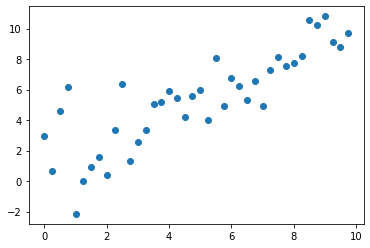

In [95]:
%matplotlib inline
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
from numpy.random import normal, seed
import sklearn.linear_model as slm
from sklearn.preprocessing import scale
import sklearn.model_selection as ms
from math import sqrt
import keras
import keras.models as models
import keras.layers as layers
from keras.layers import Dropout, LeakyReLU
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from tensorflow import set_random_seed

seed(34567)
x = np.arange(start = 0.0, stop = 10.0, step = 0.25) 
y = np.add(x, normal(scale = 2.0, size = x.shape[0]))

plt.scatter(x,y)

Обратите внимание, что эти точки данных находятся примерно на прямой линии, но со значительными отклонениями.

Далее вы вычислите простую модель одиночной регрессии. Эта модель имеет член перехвата и один параметр наклона. Код в ячейке ниже разбивает данные на произвольно выбранные подмножества обучения и тестирования. Выполните этот код.

In [96]:
indx = range(len(x))
seed(9988)
indx = ms.train_test_split(indx, test_size = 20)
x_train = np.ravel(x[indx[0]])
y_train = np.ravel(y[indx[0]])
x_test = np.ravel(x[indx[1]])
y_test = np.ravel(y[indx[1]])

Далее мы будем использовать линейную модель в пакете `sklearn.linear_model` для создания единой регрессионной модели для этих данных. Код в ячейке ниже делает именно это, печатает коэффициент одной модели и отображает результат. Выполните этот код.

[2.18028763]


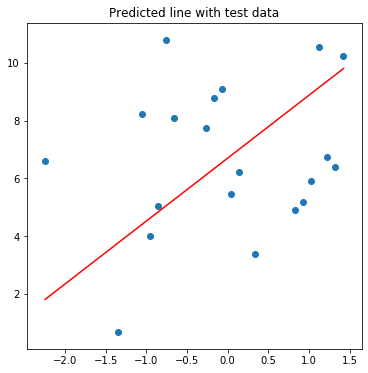

In [97]:
def plot_reg(x, y_score, y):
    ax = plt.figure(figsize=(6, 6)).gca() # define axis
    
    ## Get the data in plot order
    xy = sorted(zip(x,y_score))
    x = [x for x, _ in xy]
    y_score = [y for _, y in xy]

    ## Plot the result
    plt.plot(x, y_score, c = 'red')
    plt.scatter(x, y)
    plt.title('Predicted line with test data')

def reg_model(x, y):
    mod = slm.LinearRegression()
    x_scale = scale(x)  # .reshape(-1, 1)
    mod.fit(x_scale, y)
    print(mod.coef_)
    return mod, x_scale, mod.predict(x_scale)

mod, x_scale, y_hat = reg_model(x_train.reshape(-1, 1), y_train)

plot_reg(x_scale, y_hat, y_train)

Изучите эти результаты. Обратите внимание, что единый коэффициент (наклон) кажется разумным, учитывая стандартизацию обучающих данных. Визуально соответствие данных тренировке также выглядит разумным.

Мы также должны проверить соответствие некоторым тестовым данным. Код в ячейке делает именно это и возвращает ошибку RMS. выполнить этот код

1.9292639905624638

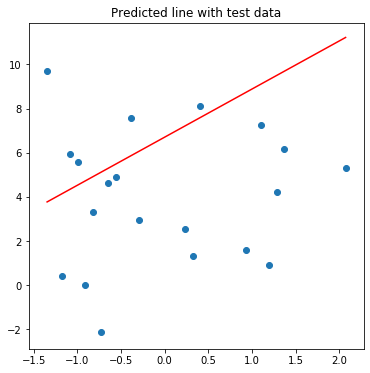

In [98]:
from math import sqrt
def test_mod(x,y, mod):
    x_scale = scale(x)
    y_score = mod.predict(x_scale)
    plot_reg(x_scale, y_score, y)
    return np.std(y_score - y)

test_mod(x_test.reshape(-1, 1), y_test, mod)

Опять же, эти результаты выглядят разумно. RMSE относительно мала, учитывая значительный разброс в этих данных.

Теперь попробуйте модель со значительно большей емкостью. В этом случае мы вычисляем новую функцию для полиномиальной модели 9-го порядка. Используя этот новый набор данных, обучается регрессионная модель и выводится сводная информация.

[    3801.79377101   -55910.91605895   340393.61244177 -1135034.00389994
  2291726.97962741 -2884767.48230414  2217807.98144177  -954167.45864495
   176179.90377912]
0.7329681695593488


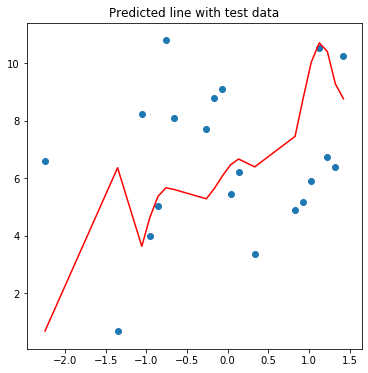

In [99]:
seed(2233)
x_power = np.power(x_train.reshape(-1, 1), range(1,10))
x_scale = scale(x_power)

mod_power = slm.LinearRegression()
mod_power.fit(x_scale, y_train)
y_hat_power = mod_power.predict(x_scale)

plot_reg(x_scale[:,0], y_hat_power, y_train)

print(mod_power.coef_)
print(np.std(y_hat_power - y_train))

Обратите внимание на следующее, что указывает на то, что модель переобучена.
- Существует широкий диапазон значений коэффициентов в 7 порядков. Эта ситуация отличается от коэффициента модели единственной регрессии, которая имела разумное однозначное значение.
- График подогнанной модели показывает очень сложное поведение. В действительности такое поведение указывает на то, что модель «изучает данные».

Теперь мы попытаемся протестировать модель с данными тестирования. Код в ячейке ниже создает те же функции и применяет метод «предиката» к модели с использованием этих функций тестирования.

1005937.9130351634


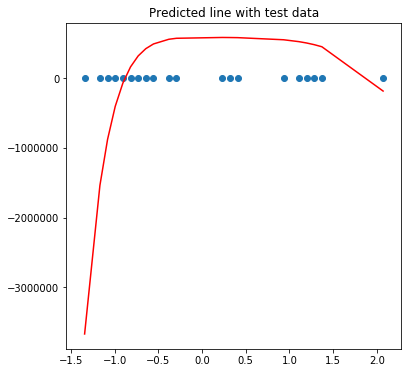

In [100]:
x_test_scale = scale(x_test.reshape(-1, 1)) # Prescale to prevent numerical overflow. 
x_test_power = np.power(x_test_scale, range(1,10))
x_scale_test = scale(x_test_power)

y_hat_power = mod_power.predict(x_scale_test)

plot_reg(x_scale_test[:,0], y_hat_power, y_test)

print(np.std(y_hat_power - y_test))

Это явно ужасное переобучение! RMSE огромна, и кривая прогнозируемых значений мало похожа на тестовые значения. Действительно, это общая проблема с моделями с избыточным обучением, когда ошибки очень быстро растут по направлению к границам области данных обучения. Можно определенно утверждать, что эта модель **не обобщается на тестовые данные**.

## l2 регуляризация

Теперь мы рассмотрим один из наиболее широко используемых методов регуляризации, часто называемый регуляризацией l2.

Этот же метод называется другими именами, поскольку он был «изобретен» несколько раз. В частности, этот метод известен как **регуляризация Тихонова**, **l2 регуляризация нормы**, **предварительное отбеливание** в технике, а для линейных моделей **регрессия гребня**. По всей вероятности, метод был впервые разработан русским математиком Андреем Тихоновым в конце 1940-х годов. Его работа не была широко известна на Западе со времени его короткой книги на эту тему «Решение некорректных задач»(https://www.researchgate.net/publication/44438630_Solutions_of_ill-posed_problems_Andrey_N_Tikhonov_and_Vasiliy_Y_Arsenin), которая была опубликована на английском языке только в 1977 году, примерно через 30 лет после ее появления на русском языке.

![](img/Tikhonov_board.jpg)
<center>
Мемориальная доска Андрею Николаевичу Тихонову в МГУ

Итак, какова основная идея? Регуляризация l2 применяет **штраф**, пропорциональный **l2** или **евклидовой норме** весов модели к функции потерь. Тогда функция полной потери становится:

$$J(W) = J_{MLE}(W) + \lambda ||W||^2$$

где,

$$||W||^2 = \big( w_1^2 + w_2^2 + \ldots + w_n^2 \big)^{\frac{1}{2}} = \Big( \sum_{i=1}^n w_i^2 \Big)^{\frac{1}{2}}$$

Мы называем $||W||^2$ l2 нормой весов, так как мы возводим в квадрат веса, суммируем, а затем берем квадратный корень или $\frac{1}{2}$ степени.

Вы можете думать об этом наказании как об ограничении l2 или евклидовой нормы вектора веса модели. Значение гиперпараметра $\lambda$ определяет, насколько норма вектора коэффициентов ограничивает решение. Вы можете увидеть представление этой геометрической интерпретации на рисунке ниже.

![](img/L2.jpg)
<center> Геометрический вид регуляризации l2

Обратите внимание, что для постоянного значения l2 значения параметров модели $B1$ и $B2$ связаны между собой. Например, если $B1$ максимизирован, то $B2 \sim 0$ или наоборот. Важно отметить, что регуляризация l2 является **мягким ограничением**. Коэффициенты приближаются, но, вероятно, не совсем к нулю.   


### Регуляризация для регрессии

Давайте вернемся к примеру регрессии. Напомним, что модель полиномиальной регрессии 9-го порядка была сильно переобучена. Может ли регуляризация l2 помочь в этой ситуации? Мы можем создать модель с применением регуляризации и выяснить это.

Код в ячейке ниже использует модель `Ridge` из` sklearn.linear_model`. Модель Ridge имеет аргумент alpha, который соответствует параметру регуляризации в обозначениях, которые мы использовали. Выполните код и проверьте результат.

1.6411533913788632
[0.20408965 0.17704734 0.16126008 0.14938273 0.13910696 0.12970734
 0.12089205 0.11252201 0.10452947]


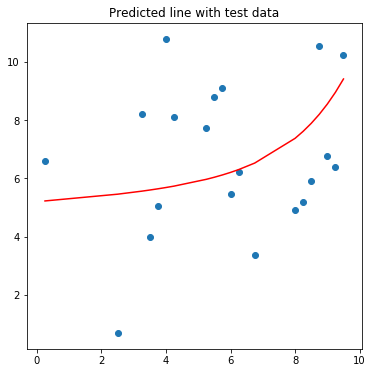

In [101]:
mod_L2 = slm.Ridge(alpha = 100.0)
mod_L2.fit(x_scale, y_train)
y_hat_L2 = mod_L2.predict(x_scale)

print(np.std(y_hat_L2 - y_train))
print(mod_L2.coef_)

plot_reg(x_train, y_hat_L2, y_train)

Эта модель сильно отличается от нерегулируемой, которую мы обучали ранее.
- Все коэффициенты имеют небольшие значения. Некоторые из коэффициентов значительно меньше 1. Эти небольшие коэффициенты являются прямым результатом штрафа l2.
- Приведенная кривая выглядит довольно разумно, учитывая шум.

Теперь протестируйте модель на тестовых данных. Выполните код в ячейке ниже и проверьте результаты.

2.4507444626408863


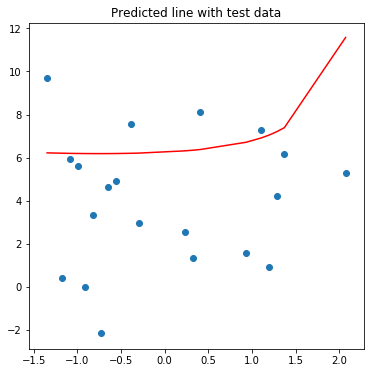

In [102]:
y_hat_L2 = mod_L2.predict(x_scale_test)

plot_reg(x_scale_test[:,0], y_hat_L2, y_test)

print(np.std(y_hat_L2 - y_test))

Этот результат выглядит намного более разумным. Среднеквадратичное отклонение почти такое же, как для примера регрессии с одним признаком. Также прогнозируемая кривая выглядит разумной.

Таким образом, мы видели, что регуляризация l2 значительно улучшает результат для полиномиальной регрессии 9-го порядка. Коэффициенты находятся в разумных пределах, а прогнозы гораздо более разумны, чем модели без ограничений.

### l2 регуляризация для моделей глубокого обучения

Итак, вы можете задаться вопросом, насколько хорошо l2 регуляризация применяется к нейронным сетям? Давайте попробуем использовать полиномиальные данные 9-го порядка.

Код в ячейке ниже определяет и подгоняет модели регрессии с одним скрытым слоем из 128 единиц. В этой первой модели регуляризация не применяется.

In [103]:
nr.seed(345)
set_random_seed(4455)
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, )))
nn.add(layers.Dense(1))
nn.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = nn.fit(x_scale, y_train, 
                  epochs = 30, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                   verbose = 0)

При подгонке модели, давайте посмотрим на функцию потерь относительно тренировочных эпох. Выполните код в ячейке ниже и проверьте результат.

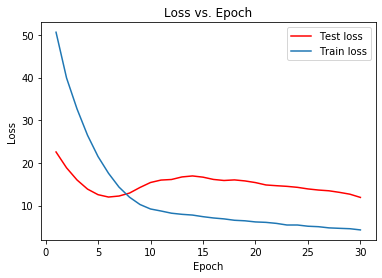

In [104]:
def plot_loss(history):
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    x = list(range(1, len(test_loss) + 1))
    plt.plot(x, test_loss, color = 'red', label = 'Test loss')
    plt.plot(x, train_loss, label = 'Train loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    
plot_loss(history) 

Похоже, что эта модель становится переобученной после 3 или 4 тренировочных эпох.

Выполните код в ячейке ниже, чтобы вычислить и построить прогноз для неограниченной модели.

5.290538068196128


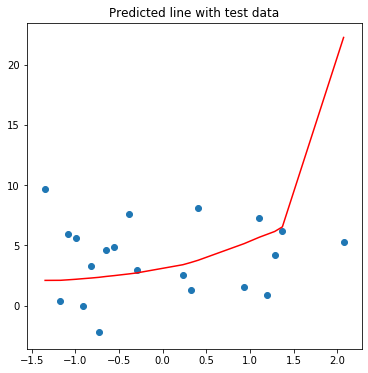

In [105]:
history = nn.fit(x_scale, y_train, 
                  epochs = 4, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                   verbose = 0)
predicted = nn.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predicted, y_test)
print(np.std(predicted - y_test))

Как высокое среднеквадратичное среднеквадратичное отклонение, так и поведение предсказанной кривой указывают на то, что эта модель вообще не обобщает. В частности, обратите внимание, как предсказанная кривая удаляется от значений тестовых данных справа.

Теперь мы попытаемся улучшить этот результат, применяя регуляризацию l2-нормы к нейронной сети. Код в ячейке ниже добавляет регуляризацию l2 к модели. Выполните код и изучите результаты.

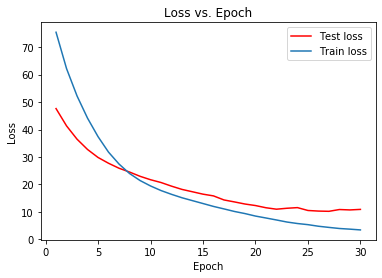

In [106]:
nr.seed(45678)
set_random_seed(45546)
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                        kernel_regularizer=regularizers.l2(2.0)))
nn.add(layers.Dense(1))
nn.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = nn.fit(x_scale, y_train, 
                  epochs = 30, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)
plot_loss(history)

Эта функция потерь немного отличается от модели без ограничений. Понятно, что регуляризация позволяет еще много тренировочных эпох, прежде чем модель станет переобученной.

Но прогнозы лучше? Выполните код в ячейке ниже и узнайте.

3.6654207570413466


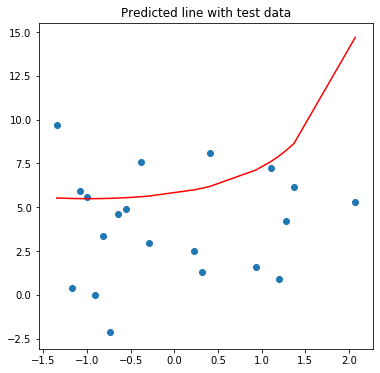

In [107]:
history = nn.fit(x_scale, y_train, 
                  epochs = 30, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)
predicted = nn.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predicted, y_test)
print(np.std(predicted - y_test))

Регуляризация l2 снизила RMSE. Не менее важно и то, что патологическое поведение предсказанных значений справа уменьшается, но явно не устраняется. Эффект смещения также виден. Обратите внимание, что левая часть подогнанной кривой теперь смещена вверх.

****************
**Упражнение 1:** Теперь вы попробовали l2 регуляризацию с одним выбором гиперпараметра регуляризации, а именно с параметром регуляризации. Поиск хорошего выбора для параметра регуляризации может потребовать проб и ошибок. Цель состоит в том, чтобы найти значение, которое дает минимальную ошибку теста.

В ячейках кода ниже создайте модели следующим образом:
1. Параметр регуляризации 20.0 с использованием `numpy.random.seed` 9456 и `set_random_seed` для серверной части TensorFlow 55566
2. Параметр регуляризации 200.0 с использованием `numpy.random.seed` 9566 и `set_random_seed` для бэкэнда TensorFlow 44223.

Составьте историю потерь для обеих моделей. Убедитесь, что вы даете моделям разные имена.

In [142]:
nr.seed(9456)
set_random_seed(55566)


In [143]:
nr.seed(9566)
set_random_seed(44223)


Затем в ячейках ниже вы создадите код для вычисления и построения прогнозных значений для вашей модели для тестовых данных вместе с метрикой ошибки. Добавьте значения тестовых данных на свой график.

In [110]:
history20 = nn20.fit(x_scale, y_train, 
                  epochs = 30, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)
predicted20 = nn20.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predicted20, y_test)
print(np.std(predicted20 - y_test))

NameError: name 'nn20' is not defined

In [111]:
history200 = nn200.fit(x_scale, y_train, 
                  epochs = 30, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)
predicted200 = nn200.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predicted200, y_test)
print(np.std(predicted200 - y_test))

NameError: name 'nn200' is not defined

Наконец, сравните результаты для трех моделей со значениями гиперпараметров регуляризации 2,0, 20,0 и 200,0. Обратите внимание, как RMSE улучшается с увеличением гиперпараметра. Также обратите внимание, что тестовые потери для самого высокого значения гиперпараметра уменьшаются наиболее равномерно, что указывает на меньшее переобучение модели.

## l1 регуляризация

Мы также можем создать регуляризацию, используя другие нормы. Метод **l1 регуляризации** или **Lasso** ограничивает сумму абсолютных значений коэффициентов модели. Норму l1 иногда называют **нормой Манхэттена**, поскольку расстояние измеряется так, как если бы вы путешествовали по прямоугольной сетке улиц. Это противоречит норме l2, которая измеряет расстояние «по прямой линии».

Мы можем вычислить l1 норму весов следующим образом:

$$||W||^1 = \big( |w_1| + |w_2| + \ldots + |w_n| \big) = \Big( \sum_{i=1}^n |w_i| \Big)^1$$

где $|x|$ - абсолютное значение $x$.

Обратите внимание, что для вычисления нормы l1 мы возводим сумму абсолютных значений в первую степень.

Как и в случае регуляризации l2, в регуляризации l1 мы используем штрафной член нормы l1 весов. Множитель штрафа, $\alpha$, определяет, насколько норма вектора коэффициентов ограничивает значения весов. Полная функция потери тогда становится:

$$J(W) = J_{MLE}(W) + \alpha ||W||^1$$

Вы можете увидеть представление этой геометрической интерпретации на рисунке ниже.

![](img/L1.jpg)
<center>Геометрический вид регуляризации L1

Обратите внимание, что на рисунке, если $B1 = 0$, то $B2$ имеет значение в пределе или наоборот. Другими словами, использование ограничения нормы l1 приводит к тому, что некоторые весовые значения обнуляются, что позволяет другим коэффициентам принимать правильные значения. Таким образом, ограничение нормы l1 **выбивает** некоторые веса из модели в целом. В отличие от регуляризации l2, регуляризация l1 приводит некоторые коэффициенты к нулю.

### l1 регуляризация

Имея в виду эти идеи, давайте применим регуляризацию l1-нормы к проблеме полиномиальной регрессии 9-го порядка. Код в ячейке ниже применяет регуляризацию l1 или регуляризацию Лассо к задаче линейной регрессии. Выполните этот код и проверьте результаты.

2.9447844435467823
[0.18028763 0.         0.         0.         0.         0.
 0.         0.         0.        ]


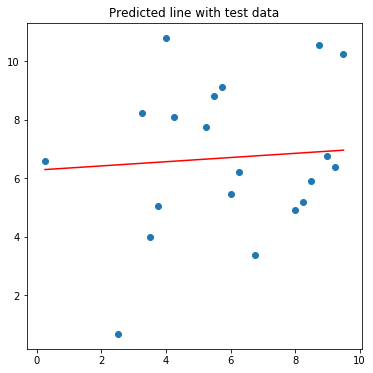

In [112]:
mod_L1 = slm.Lasso(alpha = 2.0, max_iter=100000)
mod_L1.fit(x_scale, y_train)
y_hat_L1 = mod_L1.predict(x_scale)

print(np.std(y_hat_L1 - y_test))
print(mod_L1.coef_)

plot_reg(x_train, y_hat_L1, y_train)

Обратите внимание на следующее о результатах этой l1 регуляризованной регрессии:
- Многие из коэффициентов равны 0, как и ожидалось.
- подогнанная кривая выглядит разумно.

Теперь выполните код в ячейке ниже и проверьте результаты прогнозирования. 

2.86372211908772


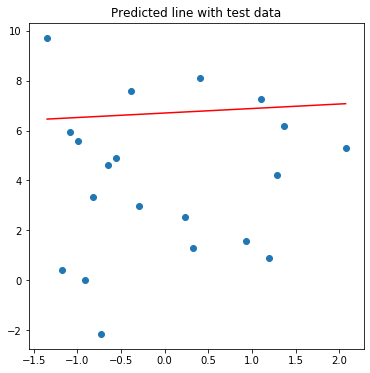

In [113]:
y_hat_L1 = mod_L1.predict(x_scale_test)

plot_reg(x_scale_test[:,0], y_hat_L1, y_test)

print(np.std(y_hat_L1 - y_test))

Среднеквадратичное отклонение значительно снижено и меньше, чем для регрессии с регуляризацией l2. График прогнозируемых значений выглядит аналогично модели одиночной регрессии, но с некоторым смещением.


### Нейронная сеть с регуляризацией l1

Теперь попробуем регуляризацию l1 с нейронной сетью. Код в ячейке ниже определяет, подгоняет и строит график однослойной нейронной сети с использованием регуляризации l1. Выполните этот код и проверьте результаты.

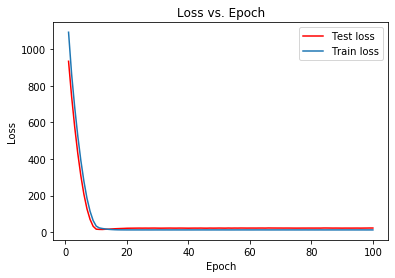

In [145]:
nr.seed(45678)
set_random_seed(45546)
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                        kernel_regularizer=regularizers.l1(10.0)))
nn.add(layers.Dense(1))
nn.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = nn.fit(x_scale, y_train, 
                  epochs = 100, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)
plot_loss(history)

В результате регуляризации l1, потеря тренировки не проявляет признаков переобучения в течение нескольких эпох.

Затем выполните код в ячейке ниже, чтобы вычислить и отобразить прогнозные значения обученной сети.

2.999632487663449


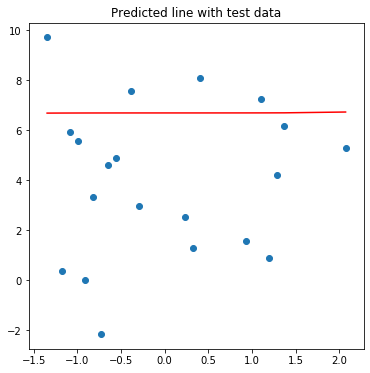

In [146]:
history = nn.fit(x_scale, y_train, 
                  epochs = 40, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  verbose = 0)
predicted = nn.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predicted, y_test)
print(np.std(predicted - y_test))

Эти результаты являются определенным улучшением. RMSE аналогична той, которую производит нейронная сеть с регуляризацией l2. Кроме того, кривая подгонки показывает аналогичное поведение и смещение. Это смещение является результатом регуляризации.

## Ранняя остановка

Ранняя остановка концептуально проста. Ранняя остановка прекращает обучение модели нейронной сети в эпоху до того, как она станет ужасно переобученной. Это идея ранней остановки.

Фактически, мы уже использовали раннюю остановку при создании и тестировании вышеупомянутых регуляризованных моделей. Вопрос в том, как нам автоматизировать этот процесс?

### Алгоритм ранней остановки

Алгоритм ранней остановки прост. Этот псевдокод показывает основной цикл для ранней остановки в эпоху с более низкой метрикой производительности, которая выполняется после обучающей эпохи модели.

`Do while TRUE:  
    store current model parameters   
    update model for epoch  
    if(performance_for_epoch < stored_performance_metric)  
        return stored_model  
    else  
        stored_performance_metric = performance_for_epoch   
        store_model = model  
`  



### Как работает ранняя остановка?

Ранняя остановка прекращает обучение модели до того, как произойдет переобучение. Но как мы можем интерпретировать это действие в терминах функции потерь $J(W)_{MLE}$? Рисунок ниже дает некоторое представление об этом.

![](img/EarlyStopping.JPG) 
<center>Влияние ранней остановки на $J(W)_{MLE}$</center>

С левой стороны диаграммы вы можете увидеть контуры весовой нормы. Справа - ранняя остановка прекращает обучение при некоторой модельной весовой норме $||W||^2$. В идеале это в тот момент, когда тренировка $J(W)_{MLE}$  начинает переобучать. Таким образом, мы можем думать о ранней остановке как о регуляризации нормы l2, где мы записываем функцию потерь как:

$$argmin_W J(W) = J(W)_{MLE} + \alpha ||W||^2$$

где,

$\alpha = $ параметр регуляризации, управляющий точкой остановки. 

### Пример ранней остановки

Ручное применение ранней остановки является неэффективным в вычислительном отношении и довольно утомительным. К счастью, у Keras есть встроенная возможность, которая позволяет автоматизировать это.

Для реализации этой ранней остановки нам нужно определить 2 обратных вызова Keras. Требуется два таких обратных вызова:
1. Первый обратный вызов, **EarlyStopping**, предназначен для метода ранней остановки.
2. Второй обратный вызов **checkpoints** для сохранения текущей модели.

Эти обратные вызовы определены в виде **callbacks list**.

Обратите внимание, что определенная модель включает l2 регуляризацию. Таким образом, эта модель должна давать производительность, наблюдаемую при ручной ранней остановке. Чтобы увидеть, как это работает, проверьте и затем выполните код в следующей ячейке.

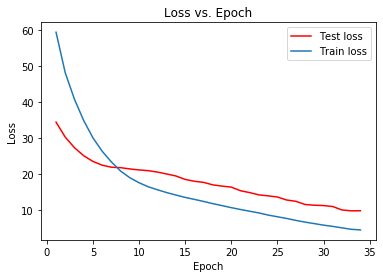

In [147]:
## First define and compile a model. 
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, ),
                        kernel_regularizer=regularizers.l2(1.0)))
nn.add(layers.Dense(1))

nn.compile(optimizer = 'RMSprop', loss = 'mse', metrics=['mse', 'mae'])

## Define the callback list
filepath = 'my_model_file.hdf5' # define where the model is saved
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_loss', # Use loss to monitor the model
        patience = 1 # Stop after one step with lower accuracy
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = filepath, # file where the checkpoint is saved
        monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
        save_best_only = True # Only save model if it is the best
    )
]

## Now fit the model
nr.seed(5566)
set_random_seed(6767)
history = nn.fit(x_scale, y_train, 
                  epochs = 40, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 0)

## Visualize the outcome
plot_loss(history)

Вы можете видеть, что поведение потери в эпоху обучения ведет себя так же, как при одной регуляризации l2. Обратите внимание, что обучение было автоматически прекращено в тот момент, когда функция потерь достигает своего оптимального уровня.

Давайте также посмотрим на точность относительно эпох. Выполните код в ячейке ниже и проверьте результат.

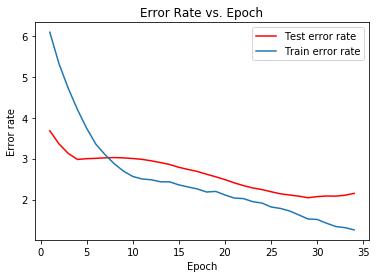

In [148]:
def plot_accuracy(history):
    train_acc = history.history['mae']
    test_acc = history.history['val_mae']
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color = 'red', label = 'Test error rate')
    plt.plot(x, train_acc, label = 'Train error rate')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Error rate')
    plt.title('Error Rate vs. Epoch')  
    
plot_accuracy(history)  

Кривая точности теста соответствует тестовым потерям.

Код в ячейке ниже извлекает лучшую модель (по нашим критериям остановки) из хранилища, вычисляет прогнозы и отображает результат. Выполните этот код и проверьте результаты.

4.1702120918310435


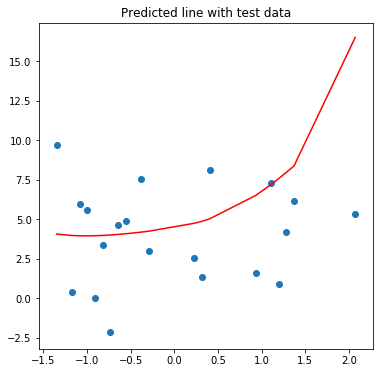

In [149]:
best_model = keras.models.load_model(filepath)
predictions = best_model.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predictions, y_test)
print(np.std(predictions - y_test))

Как и ожидалось, эти результаты похожи, но немного хуже, чем результаты, полученные при ручной остановке тренировки регуляризованной нейронной сети l2.

## Регуляризация отсева

Все методы регуляризации, которые мы обсуждали до сих пор, возникли задолго до нынешней эры глубоких нейронных сетей. Теперь рассмотрим метод **регуляризации отсева**. Из всех широко используемых методов регуляризации отсев является одним из немногих, специально разработанных для нейронных сетей. Оригинальный документ, [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting by Srivastava et. al](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf), 2014 год, достаточно читабелен и дает гораздо больше подробностей, чем представлено здесь.

Мы уже видели, как нормализация l1 выбивает некоторые модельные веса. Метод отсева упорядочивает нейронные сети, создавая **ансамбль** сетей с некоторой долей $p \lt 1.0$ удаленных скрытых единиц. Известно, что методы ансамбля являются сильными регуляризаторами и дают превосходные результаты, комбинируя обучение нескольких **слабых учеников**.

Метод отсева несколько отличается от других методов ансамбля, таких как пакетирование. Эта схема перевешивания имеет несколько преимуществ:
- Веса моделей для результирующих сетей пересчитываются с учетом вероятностей их выборки в ансамбле.
- Память, необходимая для обучения модели, просто $O(n)$, где n - количество весов. Для модели в пакете требуется $O(M * n)$, где $M$ - количество моделей в пакете.
- При прогнозировании используется только одна модель. В тоже время, прогнозы для каждой модели в пакете должны быть рассчитаны для пакета.

Чтобы понять этот метод, давайте вспомним базовую модель вывода l-го слоя в полностью связанной сети:

$$z^{(l+1)}_i = w^{(l+1)}_i \cdot h^{(l)} + b^{(l+1)}_i\\
h^{(l+1)}_i = \sigma(z^{(l+1)}_i)$$

где:

$\sigma = $ функция активации.

Теперь нам нужно выбрать скрытые единицы с вероятностью $p$, и в этом случае мы можем написать:

$$r^{(l)}_i \sim Bernoulli(p)\\
\tilde{h}^{(l)}_i = r^{(l)}_i * y^{(l)}\\
z^{(l+1)}_i = w^{(l+1)}_i \cdot \tilde{h}^{(l)}_i + b^{(l+1)}_i\\
h^{(l+1)}_i = \sigma(z^{(l+1)}_i)$$

где:

$r^{(l)}_i =$ выпадающий вектор со значениями $\{0,1\}$.

Чтобы понять, что это означает на практике, изучите рисунок. На этом рисунке показана полностью связанная сеть с 4 скрытыми модулями и вероятностью выпадения $p = 0,5$.

![](img/DropoutExample.JPG)
![](img/DropoutExample2.JPG)

<center>Возможные отсевы для простой полностью связанной сети с p = 0,5 </center>

Изучите рисунок и обратите внимание на следующее:

- Есть 6 способов добиться отсева с ровно половиной единиц, как показано на рисунке.
- Никакие единицы не могут выпасть с вероятностью $p^4$.
- Одна единица может выпасть с вероятностью $p^3 (1-p)$.
- Все единицы могут выпасть с вероятностью $(1-p)^4$. Этот случай недопустим, поэтому его не следует учитывать.

На самом деле существует $n^2$ возможных шаблонов отсева для скрытого слоя с n единицами. Такое масштабирование быстро приводит к проблеме. Для сети любого реалистичного размера невозможно полностью отобрать все возможности. Вместо этого нам нужно использовать какое-то приближение с разумным количеством выборок.

В идеале нам нужна модель, которая дает нам апостериорную вероятность $y$, выходной сигнал, при условии, что $x$ вход, который мы можем записать в виде $p(y\ |\ x)$. Если бы у нас было бесконечное количество вычислительных ресурсов, мы могли бы  попробовать распределение Монте-Карло для нашей нейронной сети. Эта идеальная эталонная нейронная сеть известна как **байесовская сеть**. Очевидно, что для крупномасштабных сетей не представляется возможным рассчитать этот результат.

Мы должны согласиться на выборочный результат. Мы выполним перевешивание с вероятностью того, что образец создан. Продолжая обозначения, которые мы использовали, мы сможем написать:

$$p(y\ |\ x) \sim \sum_r p(r) p(y\ |\ x, r)$$

где,

$r = $ вектор выборочной маски Бернулли.

При наличии достаточного количества выборок приведенное выше приближение будет сходиться к желаемому распределению вероятности. Однако на практике было обнаружено, что среднее геометрическое ансамбля сходится быстрее.

### Вычисление нейронной сети с регуляризацией отсева

Имея немного теории, мы теперь применим регуляризацию отсева для обучения нейронной сети. Код в ячейке ниже определяет нейронную сеть с выпадающим слоем с $p = 0.5$. Остальная часть этой сети идентична другим сетям, с которыми мы работали. Выполните этот код и проверьте результат.

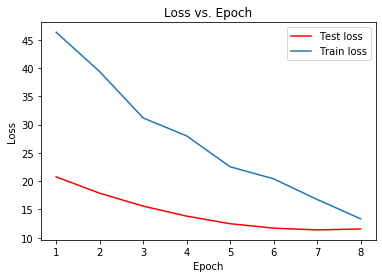

In [150]:
## First define and compile a model with a dropout layer. 
nn = models.Sequential()
nn.add(layers.Dense(128, activation = 'relu', input_shape = (9, )))
nn.add(Dropout(rate = 0.5)) # Use 50% dropout on this model
nn.add(layers.Dense(1))
nn.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])

## Now fit the model
nr.seed(1144)
set_random_seed(6723)
history = nn.fit(x_scale, y_train, 
                  epochs = 40, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 0)

## Visualize the outcome
plot_loss(history)

Знакомый график потерь здесь выглядит немного иначе. Обратите внимание на изломы на кривой тренировочных потерь. Это, вероятно, результат отсева.

Выполните код в ячейке ниже и проверьте кривые точности относительно эпох.

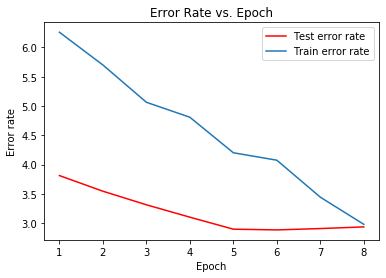

In [151]:
plot_accuracy(history)

Поведение кривой точности обучения имеет вид, аналогичный кривой потерь с точки зрения переломов.

Выполните код в ячейке ниже, чтобы проверить результаты прогнозирования для этой модели.

4.1702120918310435


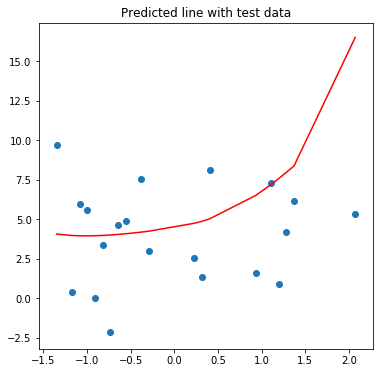

In [152]:
best_model = keras.models.load_model(filepath)
predictions = best_model.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predictions, y_test)
print(np.std(predictions - y_test))

Эти результаты выглядят аналогично результатам, полученным с помощью других методов регуляризации для нейронных сетей по этой задаче, в частности, ранней остановке. Хотя метод отсева является эффективным регуляризатором, он не является «серебряной пулей».

## Нормализация партии

Часто бывает так, что распределение выходных значений некоторых скрытых слоев изменяется. В результате распространяющиеся градиенты могут становиться близкими к нулю, что значительно замедляет сходимость во многих случаях. 

В 2015 году [Sergey and Szegedy](https://arxiv.org/pdf/1502.03167.pdf) представили решение этой проблемы в своей статье **Нормализация партии: ускорение обучения в глубокой сети за счет уменьшения внутреннего смещения ковариата**. Основная идея проста. Уровень нормализации партии поддерживает экспоненциальную оценку скользящего среднего значения среднего и дисперсии выходных данных уровня. Эти значения используются для нормализации выходных значений этого слоя. Другими словами, уровень нормализации партии обеспечивает постоянное распределение выходных значений.

Давайте попробуем пример. Простая модель нейронной сети, определенная в ячейке кода ниже, включает в себя уровень пакетной нормализации. Также обратите внимание, что для улучшения конвергенции ранняя остановка была изменена, чтобы иметь терпение 3. Выполните этот код.   

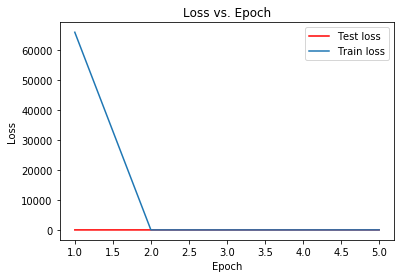

In [153]:
## Use patience of 3
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_loss', # Use loss to monitor the model
        patience = 3 # Stop after three steps with lower accuracy
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = filepath, # file where the checkpoint is saved
        monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
        save_best_only = True # Only save model if it is the best
    )
]


## Now, define an NN model using batch normalization. 
## First define and compile a model with a batch normalization layer. 
nn = models.Sequential()
nn.add(layers.Dense(128, input_shape = (9, ), activation = 'relu'))
nn.add(BatchNormalization(momentum = 0.99))
nn.add(layers.Dense(1))
## Define the optimizer and compile
optm = keras.optimizers.rmsprop(lr=1.0)
nn.compile(optimizer = optm, loss = 'mse', metrics = ['mae'])

## Now fit the model
nr.seed(345)
set_random_seed(4532)
history = nn.fit(x_scale, y_train, 
                  epochs = 100, batch_size = 1,
                  validation_data = (x_scale_test, y_test),
                  callbacks = callbacks_list,  # Call backs argument here
                  verbose = 0)

## Visualize the outcome
plot_loss(history)

Потеря быстро уменьшается, а затем остается в узком диапазоне. Похоже, что конвергенция довольно быстрая.

Как точность развивается с эпохами обучения? Выполните код в ячейке ниже, чтобы отобразить результат.

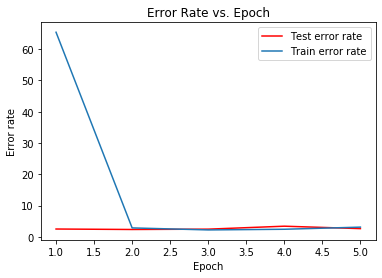

In [154]:
plot_accuracy(history)

Эта кривая точности довольно необычна. Кажется, это отражает простую используемую регуляризацию.

Наконец, выполните код в ячейке ниже, чтобы оценить прогнозы, сделанные с этой моделью.

3.038410079123879


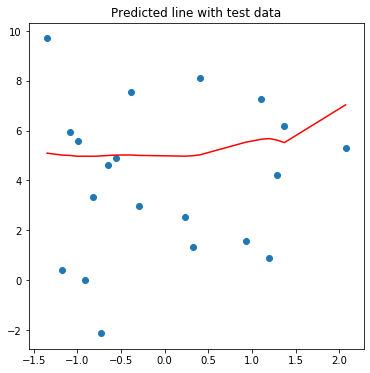

In [155]:
best_model = keras.models.load_model(filepath)
predictions = best_model.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predictions, y_test)
print(np.std(predictions - y_test))

Подгонка к тестовым данным выглядит довольно хорошо.

## Использование нескольких методов регуляризации

**Упражнение 2:** Во многих случаях применяется более одного метода регуляризации. Мы уже применяли раннюю остановку с другими методами регуляризации. В этом упражнении вы создадите нейронную сеть, используя четыре метода регуляризации одновременно:
- регуляризация l2
- регуляризация l1
- Отсев
- Ранняя остановка

В приведенной ниже ячейке создайте код для нейронной сети, используя вышеуказанные методы регуляризации. Ваш код должен включать следующее:

1. Установите семя `numpy.random` 242244 и` set_random_seed` для бэкэнда TensorFlow 4356.
2. Определите список обратного вызова с помощью «EarlyStopping» с монитором, установленным в «val_loss» и patience, установленным в 4, и «ModelCheckpoint» с монитором, установленным в «val_loss»
3. Полностью слой слой со 128 блоками и активацией ReLU. Включите регуляцию l1 и l2 с помощью функции `l1_l2` с параметром регуляризации, установленным в 50.0.
4. Выпадающий слой с параметром регуляризации, установленным на 0,5.
5. Обучите модель на 120 эпохах, с размером партии 10, используя уже определенный список обратных вызовов.

Обучите модель нейронной сети, сохраняя результаты в истории объекта.

In [125]:
nr.seed(242244)
set_random_seed(4346)



В ячейке ниже создайте и выполните код, чтобы построить историю потерь для обучения и тестирования.

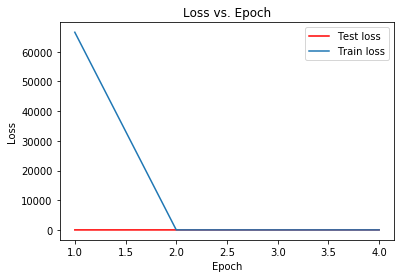

In [126]:
## Visualize the outcome
plot_loss(history)

В приведенной ниже ячейке создайте и выполните код, чтобы построить историю точности для обучения и тестирования.

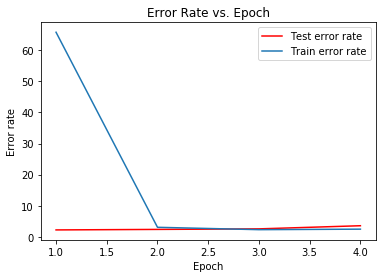

In [127]:
plot_accuracy(history)

Затем в ячейках ниже вы создадите код для вычисления и построения прогнозных значений вашей модели для тестовых данных вместе с метрикой ошибки. Добавьте значения тестовых данных на свой график.

3.3531877722090537


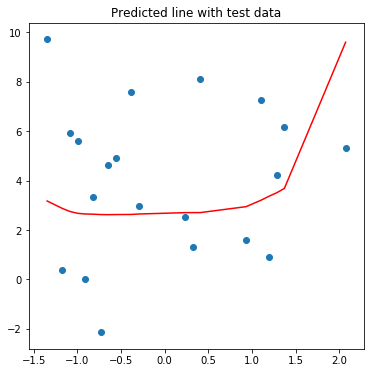

In [128]:
best_model = keras.models.load_model(filepath)
predictions = best_model.predict(x_scale_test)
plot_reg(x_scale_test[:,0], predictions, y_test)
print(np.std(predictions - y_test))

Как эти результаты соотносятся с использованием отдельных методов регуляризации? Были ли какие-либо улучшения в точности? Как насчет смещения в подогнанной кривой, которое весьма заметно, когда используются некоторые из отдельных методов регуляризации?